## Input

Input files:

In [1]:
# input data
outdir     = "results_hap_analysis"
metasam_fn = "metadata/samples.meta_phenotypes.txt"
accessi_fn = "/home/xavi/Documents/VariationAg1k/data/phase2.AR1/accessibility/accessibility.h5"
haploty_fn = "/home/xavi/Documents/VariationAg1k/data/phase2.AR1/haplotypes/zarr2/ag1000g.phase2.ar1.samples/"

In [2]:
# define populations
outcode    = "out"
popl       = ["AOcol","BFcol","BFgam","CIcol","CMgam","FRgam","GAgam","GHcol","GHgam","GM","GNcol","GNgam","GQgam","GW","KE","UGgam"]
popc       = "population"
chrom      = "2R"
l_nom      = "umap"

# exclude these samples
excludec   = "ox_code"
excludel   = ["NO RES"]
# traits to subset
sub1c      = "population"
sub1l      = ["AOcol","BFcol","BFgam","CIcol","CMgam","FRgam","GAgam","GHcol","GHgam","GM","GNcol","GNgam","GQgam","GW","KE","UGgam"]

# gene coordinates
ace_start = 3489213
ace_end   = 3493788
ace_119S  = 3492074

# duplication coordinates
ace_dups  = 3436800 # start duplication
ace_dupe  = 3639600 # end duplication

# flanking bp or num haps, to retain in analysis
fbp_var    = 1e4     # num bp to retain around loci of interest (duplication)

In [3]:
import numpy as np
import zarr
import pandas as pd
import allel
import h5py
import warnings
import scipy
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import itertools
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage

In [4]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx,array[idx]

## Load data

### Load genotypes

In [5]:
# LOAD DATA
print("Samples bool...")
# load samples list with sample code, groupings, locations etc.
samples_df   = pd.read_csv(metasam_fn, sep='\t')
samples_bool = (
    samples_df[popc].isin(popl).values & 
    samples_df[sub1c].isin(sub1l).values &
    ~samples_df[excludec].isin(excludel).values)
samples_sub  = samples_df[samples_bool]
samples_sub.reset_index(drop=True, inplace=True)


print("Samples dictionary...")
# indexed dictionary of populations
popdict = dict()
for popi in popl: 
    popdict[popi]  = samples_sub[samples_sub[popc] == popi].index.tolist()

# add an extra population composed of all other locations
popdict["all"] = []
for popi in popl:
    popdict["all"] = popdict["all"] + popdict[popi]

gen_pops_count = samples_sub.groupby(popc).size()
gen_pops_count

Samples bool...
Samples dictionary...


population
AOcol     78
BFcol     75
BFgam     92
CIcol     71
CMgam    297
FRgam     24
GAgam     69
GHcol     55
GHgam     12
GM        65
GNcol      4
GNgam     40
GQgam      9
GW        91
KE        48
UGgam    112
dtype: int64

### Load haplotypes

In [6]:
# haplotypes: variants
hapcall     = zarr.open(haploty_fn)
print("Load haplotype variants...")
hapcall_var = hapcall[chrom]["variants"]
hapvars     = allel.VariantChunkedTable(hapcall_var,names=["POS","REF","ALT"],index="POS")

# haplotypes: phased genotypes
print("Load haplotype haplotypes...")
hapcall_gen = hapcall[chrom]["calldata/genotype"]
haploty_gen = allel.GenotypeChunkedArray(hapcall_gen)
# find samples in haplotype dataset that coincide with genotypes
haploty_sam = hapcall[chrom]["samples"][:].astype(str)
hapsam_bool = np.isin(haploty_sam, np.array(samples_sub["ox_code"]))
haploty_gen = haploty_gen.subset(sel1=hapsam_bool)
print(haploty_gen.shape)

# recast haplotypes: drop ploidy
print("Drop ploidy haplotypes...")
haploty_hap = haploty_gen.to_haplotypes()
print(haploty_hap.shape)

Load haplotype variants...
Load haplotype haplotypes...
(12047846, 1142, 2)
Drop ploidy haplotypes...
(12047846, 2284)


In [7]:
# haplotype dicts
# arrays of hap ids and populations of each hap (double the size of genotype arryays: 2 haps per individual except in X chromosome)
print("Samples dictionary for haps...")
is_samp_in_hap = np.isin(np.array(samples_sub["ox_code"]),haploty_sam)
hap_ids        = np.array(list(itertools.chain(*[[s + 'a', s + 'b'] for s in haploty_sam[hapsam_bool]])))
hap_pops       = np.array(list(itertools.chain(*[[s, s] for s in np.array(samples_sub[popc][is_samp_in_hap])])))
hap_pops_count = pd.DataFrame(data={ popc : np.unique(hap_pops,return_counts=True)[0], "counts" : np.unique(hap_pops,return_counts=True)[1] }).set_index(popc)
hap_pops_df    = pd.DataFrame(data={ popc : hap_pops})

# pop dicts for haplotype data
popdicthap = dict()
for popi in popl: 
    popdicthap[popi]  = hap_pops_df[hap_pops_df[popc] == popi].index.tolist()

popdicthap["all"] = []
for popi in popl:
    popdicthap["all"] = popdicthap["all"] + popdicthap[popi]

hap_pops_count = hap_pops_df.groupby(popc).size()
hap_pops_count

Samples dictionary for haps...


population
AOcol    156
BFcol    150
BFgam    184
CIcol    142
CMgam    594
FRgam     48
GAgam    138
GHcol    110
GHgam     24
GM       130
GNcol      8
GNgam     80
GQgam     18
GW       182
KE        96
UGgam    224
dtype: int64

In [8]:
# haplotypes: allele counts
print("Allele counts haplotypes...")
hapalco_hap = haploty_hap.count_alleles_subpops(subpops=popdicthap)
print(hapalco_hap.shape)

Allele counts haplotypes...
(12047846,)


Subset:

In [9]:
# filter haplotypes: segregating alleles, no singletons
is_hapseg    = hapalco_hap["all"].is_segregating()     # segregating
is_hapnosing = hapalco_hap["all"][:,:2].min(axis=1)>2  # no singletons
filhap_bool  = (is_hapseg & is_hapnosing)

# subset
print("Apply filters haps...")
haploty_seg = haploty_hap.compress(filhap_bool)
hapvars_seg = hapvars.compress(filhap_bool)
hapalco_seg = hapalco_hap.compress(filhap_bool)
print(haploty_seg.shape)
print(hapalco_seg.shape)

# reformat hap arrays as dask (for network function)
print("Dask hapa...")
loci_pos     = allel.SortedIndex(hapcall_var['POS'])
haploty_dask = allel.GenotypeDaskArray(hapcall_gen)
haploty_dask = haploty_dask.subset(sel1=hapsam_bool)
haploty_haps = haploty_dask.to_haplotypes()
print(haploty_haps.shape)

Apply filters haps...
(6799278, 2284)
(6799278,)
Dask hapa...
(12047846, 2284)


### Load other

In [10]:
# Accessibility
print("Load accessibility array...")
accessi_df  = h5py.File(accessi_fn,mode="r")
accessi_arr = accessi_df[chrom]["is_accessible"][:]

Load accessibility array...


## Variants linked to `280S` (tagging variants)

Linked variants:

In [90]:
genilist = [3492074]
geniname = ["umap"]
genilist, geniname

([3492074], ['umap'])

Read in UMAP-based haplotype clusterings, create per-hap samples dataframe:

In [97]:
# umap classification
umap = pd.read_csv("results_hap_analysis/umap_classification.csv", sep="\t")

# per-hap sample table
sampleh = pd.DataFrame(data={
    "ox_code"    :  list(itertools.chain(*[[ s + 'a', s + 'b'] for s in samples_sub["ox_code"].values.tolist()])),    # takes col from oc_samples and duplicates it, a/b
    "population" :  list(itertools.chain(*[[ s      , s      ] for s in samples_sub["population"].values.tolist()])),
})

umap_sampleh = sampleh.merge(umap)
print(umap_sampleh.groupby(["p2_rfc_prediction","population"]).size())
print(umap_sampleh.groupby(["p2_rfc_prediction"]).size())

p2_rfc_prediction  population
0                  AOcol         156
                   BFcol         147
                   BFgam         139
                   CIcol          93
                   CMgam         594
                   FRgam          48
                   GAgam         138
                   GHcol         109
                   GHgam          14
                   GM            130
                   GNcol           8
                   GNgam          68
                   GQgam          18
                   GW            182
                   KE             96
                   UGgam         224
1                  BFcol           3
                   BFgam          45
                   CIcol          49
                   GHcol           1
                   GHgam          10
                   GNgam          12
dtype: int64
p2_rfc_prediction
0    2164
1     120
dtype: int64


In [98]:
# create dictionary of haplotypes according to umap mappings
popdich_clu = dict()
popdich_clu["m280S"] = np.where(umap_sampleh["p2_rfc_prediction"] == 1)[0]
popdich_clu["m280G"] = np.where(umap_sampleh["p2_rfc_prediction"] == 0)[0]

# allele counts
oc_hapalco_hap_clu_seg = haploty_seg.count_alleles_subpops(subpops=popdich_clu)
oc_hapalco_hap_clu_seg.shape

(6799278,)

In [99]:
flank_bp_EHH  = 1e5   # num haplotypes to retain for EHH calculations
ehh_above_thr = 0.95
ehh_below_thr = 0.5
colors = ["forestgreen","deeppink","lightsteelblue"]
loc_start = ace_dups
loc_end = ace_dupe

EHH m280S
EHH m280G


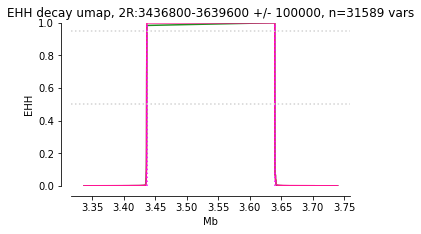

In [100]:
# variants to retain
clu_varbool_up = np.logical_and(hapvars_seg["POS"] >= loc_start-flank_bp_EHH, hapvars_seg["POS"] < loc_start)
clu_varbool_do = np.logical_and(hapvars_seg["POS"] > loc_end, hapvars_seg["POS"] <= loc_end+flank_bp_EHH)
clu_varbool    = np.logical_or(clu_varbool_up,clu_varbool_do)
# samples to remove from analysis (EHH function can't handle missing -1 data)
rmv_miss_ix   = np.unique(np.where(haploty_seg.subset(sel0=clu_varbool) == -1)[1]).tolist()
rmv_miss_bool = np.invert(np.isin(range(0,haploty_seg.n_haplotypes),test_elements=rmv_miss_ix))
# positions
clu_ehh_pos = hapvars_seg["POS"].subset(sel0=clu_varbool)
# plot
pdf = PdfPages("%s/sel_%s_%s_EHHdecay.pdf" % (outdir,chrom,l_nom))
fig = plt.figure(figsize=(5,3))
ax3 = plt.subplot(1, 1, 1)
for i,clu_key in enumerate(popdich_clu.keys()):
	print("EHH %s" % clu_key)
	# which variants include in the cluster-wise analysis of selection?
	clu_sambool = np.isin(range(0,haploty_hap.n_haplotypes),test_elements=popdich_clu[clu_key])
	clu_sambool = np.logical_and(clu_sambool,rmv_miss_bool)
	
	# calculate actual EHH
	clu_ehh_up_i = allel.ehh_decay(h=haploty_hap.subset(sel0=clu_varbool_up,sel1=clu_sambool))
	clu_ehh_do_i = allel.ehh_decay(h=haploty_hap.subset(sel0=clu_varbool_do,sel1=clu_sambool))
	clu_ehh_i    = np.concatenate((clu_ehh_up_i[::-1],clu_ehh_do_i))
	clu_ehh_i_ar = np.trapz(clu_ehh_i)
	ehh_above_start = clu_ehh_pos.compress(clu_ehh_i > ehh_above_thr)[0]
	ehh_above_end   = clu_ehh_pos.compress(clu_ehh_i > ehh_above_thr)[-1]
	ehh_below_start = clu_ehh_pos.compress(clu_ehh_i < ehh_below_thr)[0]
	ehh_below_end   = clu_ehh_pos.compress(clu_ehh_i < ehh_below_thr)[-1]
	# lab is data
	clu_lab    = "%s, n=%i, a=%.3f\nEHH>%.2f: %i bp %i-%i\nEHH<%.2f: %i bp %i-%i" % (
		clu_key, len(popdich_clu[clu_key]),clu_ehh_i_ar, 
		ehh_above_thr, ehh_above_end-ehh_above_start, ehh_above_start, ehh_above_end,
		ehh_below_thr, ehh_below_end-ehh_below_start, ehh_below_start, ehh_below_end
	)
	
	# plot EHH background & foreground
	ax3.plot(clu_ehh_pos/1e6,clu_ehh_i,color=colors[i],label=clu_lab,mfc='none')
sns.despine(ax=ax3,offset=10)
ax3.set_title("EHH decay %s, %s:%i-%i +/- %i, n=%s vars" % (l_nom,chrom,loc_start,loc_end,flank_bp_EHH,clu_ehh_pos.shape[0]))
ax3.set_xlabel("Mb")
ax3.set_ylabel("EHH")
ax3.set_ylim(0,1)
plt.axhline(ehh_above_thr, color='lightgray',linestyle=":",label=str(ehh_above_thr))
plt.axhline(ehh_below_thr, color='lightgray',linestyle=":",label=str(ehh_below_thr))
plt.axvline(loc_start/1e6, color='magenta',linestyle=":",label="gene")
plt.axvline(loc_end/1e6, color='magenta',linestyle=":",label="")
# ax3.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
# save
pdf.savefig(fig,bbox_inches='tight')
pdf.close()


Garud H statistics:

m280S
H12 = 0.012383 +/- 0.000202 SE, n = 120
m280G
H12 = 0.005139 +/- 0.000114 SE, n = 2164
m280S
H2H1 = 0.902310 +/- 0.006040 SE, n = 120


/home/xavi/miniconda3/envs/ace/lib/python3.7/site-packages/ipykernel_launcher.py:71: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


m280G
H2H1 = 0.703715 +/- 0.003877 SE, n = 2164


/home/xavi/miniconda3/envs/ace/lib/python3.7/site-packages/ipykernel_launcher.py:71: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


m280S
h = 0.997505 +/- 0.000116 SE, n = 120


/home/xavi/miniconda3/envs/ace/lib/python3.7/site-packages/ipykernel_launcher.py:108: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


m280G
h = 0.996713 +/- 0.000066 SE, n = 2164


/home/xavi/miniconda3/envs/ace/lib/python3.7/site-packages/ipykernel_launcher.py:108: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


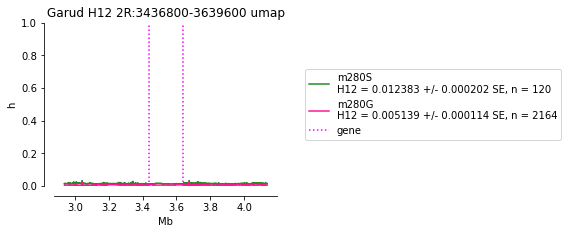

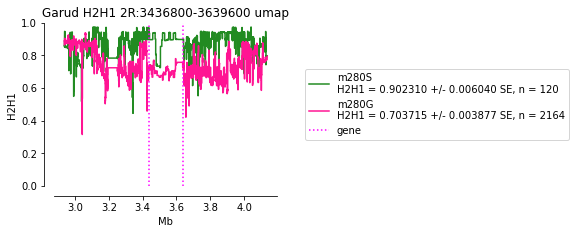

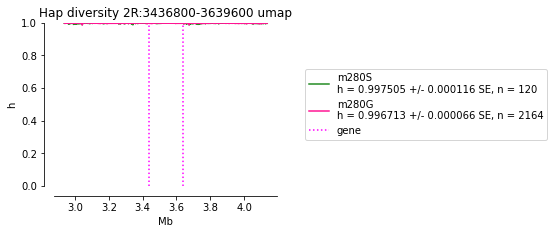

In [101]:
# Compute **Garud H statistics and haplotype diversity** for each cluster and estimates in the region of interest. Plots represent a wide region around the gene, and statistics are estimated from variants within the cluster only.
# variants to examine
block_size = 500
step_len_hap  = 100
# region to plot
flanking_bp = 5e5
clu_varbool = np.logical_and(
	hapvars_seg["POS"] >= loc_start-flanking_bp,
	hapvars_seg["POS"] <= loc_end+flanking_bp)
# region to focus: statistics will be calcualted in this region
clu_varbool_focus = np.logical_and(hapvars_seg["POS"] > loc_start-1e4, hapvars_seg["POS"] <= loc_end+1e4)


# First, for H12 plot:
# open PDF
pdf = PdfPages("%s/sel_%s_%s_GarudH12.pdf" % (outdir,chrom,l_nom))
fig = plt.figure(figsize=(4,3))
ax9 = plt.subplot(1, 1, 1)
for i,clu_key in enumerate(popdich_clu.keys()):
	# which variants include in the cluster-wise analysis of selection?
	clu_sambool = np.isin(range(0,haploty_hap.n_haplotypes),test_elements=popdich_clu[clu_key])
	clu_sambool = np.logical_and(clu_sambool,rmv_miss_bool)
	# Garud H along chromosome
	clu_pos_wib = allel.moving_statistic(
		hapvars_seg["POS"].subset(sel0=clu_varbool), statistic=lambda v: v[0], size=block_size, step=step_len_hap)
	clu_gah_wib = allel.moving_garud_h(
		haploty_hap.subset(sel0=clu_varbool,sel1=clu_sambool), size=block_size, step=step_len_hap)
	
	# garud in focus region
	gah_focus_est = allel.moving_garud_h(haploty_hap.subset(sel0=clu_varbool_focus, sel1=clu_sambool), size=block_size,step=step_len_hap)
	gah_focus_est_jack = allel.stats.misc.jackknife(gah_focus_est[1], statistic=np.nanmean)
	clu_label = "%s\nH12 = %.6f +/- %.6f SE, n = %i" % (clu_key, gah_focus_est_jack[0], gah_focus_est_jack[1],np.sum(clu_sambool))
	print(clu_label)
	# plot
	plt.step(clu_pos_wib/1e6, clu_gah_wib[1], color=colors[i], label=clu_label)
	
sns.despine(ax=ax9,offset=10)
ax9.set_title("Garud H12 %s:%i-%i %s" % (chrom,loc_start,loc_end,l_nom))
ax9.set_ylim(0,1)
ax9.set_xlabel("Mb")
ax9.set_ylabel("h")
plt.axvline(loc_start/1e6, color='magenta',linestyle=":",label="gene")
plt.axvline(loc_end/1e6, color='magenta',linestyle=":",label="")
ax9.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
# save
pdf.savefig(fig,bbox_inches='tight')
pdf.close()


# Now, same with H2/H1 plot:
# open PDF
pdf = PdfPages("%s/sel_%s_%s_GarudH2H1.pdf" % (outdir,chrom,l_nom))
fig = plt.figure(figsize=(4,3))
ax9 = plt.subplot(1, 1, 1)
for i,clu_key in enumerate(popdich_clu.keys()):
	# which variants include in the cluster-wise analysis of selection?
	clu_sambool = np.isin(range(0,haploty_hap.n_haplotypes),test_elements=popdich_clu[clu_key])
	clu_sambool = np.logical_and(clu_sambool,rmv_miss_bool)
	# Garud H along chromosome
	clu_pos_wib = allel.moving_statistic(
		hapvars_seg["POS"].subset(sel0=clu_varbool), statistic=lambda v: v[0], size=block_size,step=step_len_hap)
	clu_gah_wib = allel.moving_garud_h(
		haploty_hap.subset(sel0=clu_varbool,sel1=clu_sambool), size=block_size,step=step_len_hap)
	
	# garud in focus region
	gah_focus_est = allel.moving_garud_h(haploty_hap.subset(sel0=clu_varbool_focus, sel1=clu_sambool), size=block_size,step=step_len_hap)
	gah_focus_est_jack = allel.stats.misc.jackknife(gah_focus_est[3], statistic=np.nanmean)
	clu_label = "%s\nH2H1 = %.6f +/- %.6f SE, n = %i" % (clu_key, gah_focus_est_jack[0], gah_focus_est_jack[1],np.sum(clu_sambool))
	print(clu_label)
	# plot
	plt.subplot(1, 1, 1)
	plt.step(clu_pos_wib/1e6, clu_gah_wib[3], color=colors[i], label=clu_label)
	
sns.despine(ax=ax9,offset=10)
ax9.set_title("Garud H2H1 %s:%i-%i %s" % (chrom,loc_start,loc_end,l_nom))
ax9.set_ylim(0,1)
ax9.set_xlabel("Mb")
ax9.set_ylabel("H2H1")
plt.axvline(loc_start/1e6, color='magenta',linestyle=":",label="gene")
plt.axvline(loc_end/1e6, color='magenta',linestyle=":",label="")
ax9.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
# save
pdf.savefig(fig,bbox_inches='tight')
pdf.close()


# Finally, haplotype diversity:
# open PDF
pdf = PdfPages("%s/sel_%s_%s_hapdiv.pdf" % (outdir,chrom,l_nom))
fig = plt.figure(figsize=(4,3))
ax9 = plt.subplot(1, 1, 1)
for i,clu_key in enumerate(popdich_clu.keys()):
	# which variants include in the cluster-wise analysis of selection?
	clu_sambool = np.isin(range(0,haploty_hap.n_haplotypes),test_elements=popdich_clu[clu_key])
	clu_sambool = np.logical_and(clu_sambool,rmv_miss_bool)
	# hap div along chromosome
	clu_pos_wib = allel.moving_statistic(
		hapvars_seg["POS"].subset(sel0=clu_varbool), statistic=lambda v: v[0], size=block_size,step=step_len_hap)
	clu_hdi_wib = allel.moving_haplotype_diversity(
		haploty_hap.subset(sel0=clu_varbool,sel1=clu_sambool), size=block_size,step=step_len_hap)
	
	# garud in focus region
	gah_focus_est = allel.moving_haplotype_diversity(haploty_hap.subset(sel0=clu_varbool_focus, sel1=clu_sambool), size=block_size,step=step_len_hap)
	gah_focus_est_jack = allel.stats.misc.jackknife(gah_focus_est, statistic=np.nanmean)
	clu_label = "%s\nh = %.6f +/- %.6f SE, n = %i" % (clu_key, gah_focus_est_jack[0], gah_focus_est_jack[1],np.sum(clu_sambool))
	print(clu_label)
	# plot
	plt.subplot(1, 1, 1)
	plt.step(clu_pos_wib/1e6, clu_hdi_wib, color=colors[i], label=clu_label)
	
sns.despine(ax=ax9,offset=10)
ax9.set_title("Hap diversity %s:%i-%i %s" % (chrom,loc_start,loc_end,l_nom))
ax9.set_ylim(0,1)
ax9.set_xlabel("Mb")
ax9.set_ylabel("h")
plt.axvline(loc_start/1e6, color='magenta',linestyle=":",label="gene")
plt.axvline(loc_end/1e6, color='magenta',linestyle=":",label="")
ax9.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
# save
pdf.savefig(fig,bbox_inches='tight')
pdf.close()

